# Laboratory work Nr.1 for the module T121M501 DSP
# Number - 7
# KTU 2020 Autumn Semester
## 1. Preparation
### 1.1 Resources

[Markdown & LateX in jupyter notebooks (blog tutorial)](https://towardsdatascience.com/write-markdown-latex-in-the-jupyter-notebook-10985edb91fd)

[matplotlib.pyplot documentation (official api site)](https://matplotlib.org/api/pyplot_api.html)

[Lab assignment document (onedrive share)](https://ktuedu-my.sharepoint.com/:b:/g/personal/luksta3_ktu_lt/EYmeVPJhKfVGoMwO6w6P8vcB627vAkcsrjqFxkz5UDvWrA?e=385nli)

[Main reference article for Karplus-Strong in Python](http://flothesof.github.io/Karplus-Strong-algorithm-Python.html)

[Matlab doc for Karplus-Strong with filter()](https://www.mathworks.com/help/signal/ug/generating-guitar-chords-using-the-karplus-strong-algorithm.html)

In [18]:
import numpy as np
%matplotlib inline
from numpy import cos, sin, pi, absolute, arange
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, lfilter, firwin, freqz
from numpy import random
from scipy.ndimage.interpolation import shift
from IPython.display import Audio
from scipy.io.wavfile import write

# Specifics

$
\huge
\begin{align}
& 7 (Am) \\
E (f_1) & = 0 \\
A (f_2) & = 110 \\
D (f_3) & = 165 \\
G (f_4) & = 220 \\
B (f_5) &= 262 \\
e (f_6) &= 330
\end{align}
$


In [3]:
def karplus_strong_own_implementation(signal,n,delay):
    samples_passed = delay
    previous_value = 0
    while samples_passed < n:
        signal[samples_passed] = signal[samples_passed] + 0.5* (signal[samples_passed-delay] + signal[samples_passed-delay-1])
        samples_passed += 1
    return signal

def nir_filter_delay(fd,fs):
    return int(np.round(fd/fs))

def normalize_signal(x):
    x = x - x.mean()
    return x / (np.max(np.abs(x)))

def reverberation_filter_function(signal,N,K):
    # a = [1,0...0, -0.5,-0.5]
    # b = [1]
    a = np.concatenate(([1] , np.zeros(N-2) , [-K]),axis=0)
    b = [1]
    return lfilter(b,a,signal)

def karplus_strong_filter_function(signal,N):
    # a = [1,0...0, -0.5,-0.5]
    # b = [1]
    a = np.concatenate(([1] , np.zeros(N-3) , [-0.5,-0.5]),axis=0)
    b = [1]
    return lfilter(b,a,signal)

def string_generation(fs,fd,ts):    
    # find out the amount of delay feedback steps required for signal generation
    N = nir_filter_delay(fd,fs)

    # generate random noise in the interval of [0,1] default
    noise = np.random.rand(int(N))

    # find out the amount of zero padding necessary for a full ts length signal
    zeros_count = fd * ts - N

    # generate the zero padding array
    zeros_padding = np.zeros((int(zeros_count)))

    # merge the noise and zero padding arrays
    signal = np.concatenate((noise,zeros_padding),axis=0)

    # filter the signal using the karplus strong algorithm and a delay of N
    filtered = karplus_strong_filter_function(signal,N)

    # normalize the filtered signal
    normalized = normalize_signal(filtered)

    return signal,filtered,normalized


def accord_generation(fs_array,fd,ts,delay_length):
    # initialize an array of zeros to fill with the generated signal
    signal = np.zeros(fd*ts)

    # initialize a value of total delay for each string
    total_delay = 0

    # set the amount of discrete delay points of a given delay length
    delay_samples = delay_length*fd

    # cycle all strings of the accord and add the signal to the total
    for fs in fs_array:
        # generate the signal
        signal_0, filtered_0,normalized_0 = string_generation(fs,fd,ts)

        # shift it to simulate a delay
        normalized_0 = shift(normalized_0, total_delay, cval=0.0)

        # add the signal to our total
        signal += normalized_0

        # increase the amount of total delay for the next string
        total_delay += delay_samples

    # normalize the final signal
    signal = normalize_signal(signal)
    return signal



def convert_to_frequency_domain(signal):
    # generate a frequency domain array of the signal
    nfft = len(signal)
    S = np.abs(np.fft.fft(signal) / nfft)
    S = 20 * np.log10(S/np.max(S))
    k = np.linspace(0,nfft,nfft)
    f = k*fd/nfft
    return f,S



In [3]:
# 3.1.1 natos signalo modeliavimas

# a.) Randame N

fs = 165
fd = 44100
ts = 3

N = nir_filter_delay(fd,fs)

print(f"gavome {N} vėlinimą D stygai\n")


gavome 267 vėlinimą D stygai



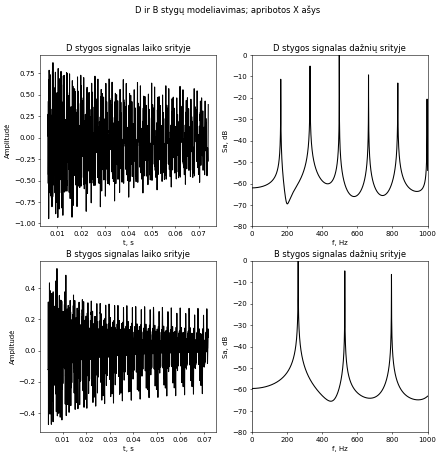

In [28]:
# c.) sumodeliuojame D ir B stygas, pavaizduojame jų laiko ir dažnių vaizdus
# randame pirmųjų trijų harmonikų dažnius. Aptarti pastebėtus spektrų panašumus ir skirtumus
fd = 44100

# D styga 165 Hz
d_fs = 165

d_n = nir_filter_delay(fd,d_fs)

d_signal, d_filtered,d_normalized = string_generation(d_fs,fd,ts)
d_f,d_S = convert_to_frequency_domain(d_normalized)


# B styga 262 Hz
b_fs = 262

b_n = nir_filter_delay(fd,b_fs)

b_signal, b_filtered,b_normalized = string_generation(b_fs,fd,ts)
b_f,b_S = convert_to_frequency_domain(b_normalized)

fig, axs = plt.subplots(2,2,figsize=(10,10),dpi=50)
#fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)

time_x = np.linspace(0,3,len(d_normalized))
axs[0,0].plot(time_x[d_n:d_n+3000],d_normalized[d_n:d_n+3000],'k')
axs[1,0].plot(time_x[b_n:b_n+3000],b_normalized[b_n:b_n+3000],'k')

#axs[0,0].plot(time_x,d_normalized,'k')
#axs[1,0].plot(time_x,b_normalized,'k')

axs[0,1].plot(d_f,d_S,'k')
axs[0,1].set_xlabel('f, Hz')
axs[0,1].set_ylabel('Sa, dB')
axs[0,1].set_xlim([0,1000])
#axs[0,1].set_xlim([0,fd/2])
axs[0,1].set_ylim([-80,0])


axs[1,1].plot(b_f,b_S,'k')
axs[1,1].set_xlabel('f, Hz')
axs[1,1].set_ylabel('Sa, dB')
axs[1,1].set_xlim([0,1000])
#axs[1,1].set_xlim([0,fd/2])
axs[1,1].set_ylim([-80,0])


axs[0,0].set_ylabel("Amplitudė")
axs[1,0].set_ylabel("Amplitudė")


axs[0,0].set_xlabel("t, s")
axs[1,0].set_xlabel("t, s")

axs[0,0].set_title("D stygos signalas laiko srityje")
axs[1,0].set_title("B stygos signalas laiko srityje")

axs[0,1].set_title("D stygos signalas dažnių srityje")
axs[1,1].set_title("B stygos signalas dažnių srityje")

fig.suptitle("D ir B stygų modeliavimas; apribotos X ašys")

plt.show()


In [29]:
write('d_note.wav',fd, d_normalized)
write('b_note.wav',fd, b_normalized)

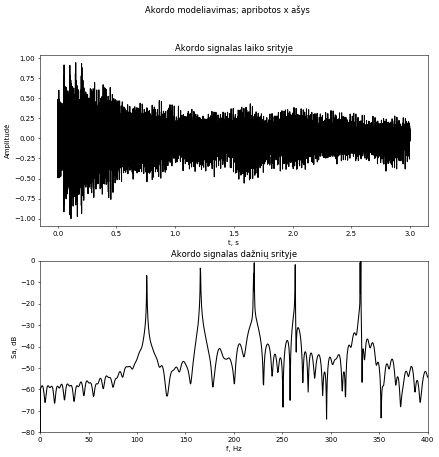

In [6]:
# 3. Akordo signalo modeliavimas

# a.) pavaizduoti pilną akordą

fs_array = [110,165,220,262,330]
fd = 44100
ts = 3
delays = 0.05

accord_signal = accord_generation(fs_array,fd,ts,delays)
accord_f,accord_S = convert_to_frequency_domain(accord_signal)

fig, axs = plt.subplots(2,1,figsize=(10,10),dpi=50)
#fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)

time_x = np.linspace(0,ts,len(accord_signal))
axs[0].plot(time_x,accord_signal,'k')


accord_signal_reverberated = reverberation_filter_function(accord_signal,N,K)
#axs[0].plot(time_x[:3000],accord_signal[:3000],'k')

axs[1].plot(accord_f,accord_S,'k')
axs[1].set_xlabel('f, Hz')
axs[1].set_ylabel('Sa, dB')
#removable limit
axs[1].set_xlim([0,400])
axs[1].set_ylim([-80,0])



axs[0].set_ylabel("Amplitudė")
axs[0].set_xlabel("t, s")

axs[0].set_title("Akordo signalas laiko srityje")
axs[1].set_title("Akordo signalas dažnių srityje")


fig.suptitle("Akordo modeliavimas; apribotos x ašys")

plt.show()

Audio(accord_signal,rate=fd)

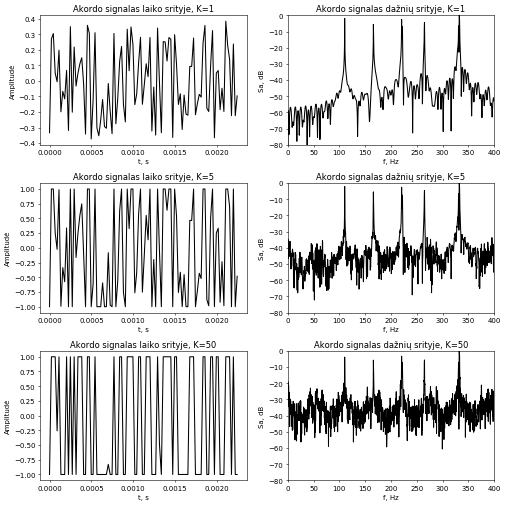

In [24]:
# Raskite akordo pirmųjų penkių harmonikų dažnius. Ar šie dažniai sutampa su akordo atskirų stygų virpėjimo dažniais?


K = [1,5,50]


def satlins(x):
    y = x
    for i in range(len(x)):
        if x[i] > 1:
            y[i] = 1
        elif x[i] < -1:
            y[i] = -1

    return y

# a.) pavaizduoti pilną akordą

fs_array = [110,165,220,262,330]
fd = 44100
fs = 3
delays = 0.05

accord_signal_base = accord_generation(fs_array,fd,ts,delays)
accords = []
accords_f = []
accords_S = []
for k in K:
    accord_signal = accord_signal_base * k
    accord_signal = satlins(accord_signal)
    accord_f,accord_S = convert_to_frequency_domain(accord_signal)
    accords.append(accord_signal)
    accords_f.append(accord_f)
    accords_S.append(accord_S)

#fig, axs = plt.subplots(len(K),2,figsize=(10,10),dpi=50)
#fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
fig, axs = plt.subplots(len(K),2,figsize=(10,10),dpi=50,constrained_layout=True)
time_x = np.linspace(0,3,len(accord_signal_base))
for i in range(len(K)):

    axs[i,0].plot(time_x[:100],accords[i][:100],'k')
    axs[i,0].set_ylabel("Amplitudė")
    axs[i,0].set_xlabel("t, s")
    axs[i,0].set_title(f"Akordo signalas laiko srityje, K={K[i]}")

    axs[i,1].plot(accords_f[i],accords_S[i],'k')
    axs[i,1].set_xlabel('f, Hz')
    axs[i,1].set_ylabel('Sa, dB')
    axs[i,1].set_xlim([0,400])
    axs[i,1].set_ylim([-80,0])
    axs[i,1].set_title(f"Akordo signalas dažnių srityje, K={K[i]}")


#fig.suptitle("Iškraipyto Akordo modeliavimas su skirtingomis K reikšmėmis")
plt.show()


In [26]:
write('accord_iskraipytas_k50.wav',fd, accords[2])

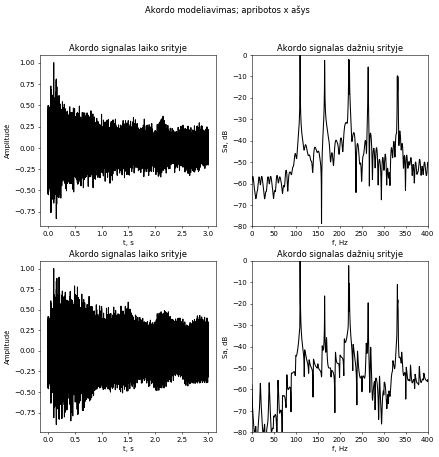

In [22]:
# 3. Reverberacijos modeliavimas


fs_array = [110,165,220,262,330]
fd = 44100
ts = 3
delays = 0.05

accord_signal = accord_generation(fs_array,fd,ts,delays)
accord_f,accord_S = convert_to_frequency_domain(accord_signal)


N = 4400
K = 0.7
accord_signal_reverberated = reverberation_filter_function(accord_signal,N,K)
accord_signal_reverberated = normalize_signal(accord_signal_reverberated)
accord_f_reverberated,accord_S_reverberated = convert_to_frequency_domain(accord_signal_reverberated)


fig, axs = plt.subplots(2,2,figsize=(10,10),dpi=50)
#fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)

time_x = np.linspace(0,ts,len(accord_signal))
axs[0,0].plot(time_x,accord_signal,'k')

axs[0,0].set_ylabel("Amplitudė")
axs[0,0].set_xlabel("t, s")

axs[0,0].set_title("Akordo signalas laiko srityje")

#axs[0].plot(time_x[:3000],accord_signal[:3000],'k')

axs[0,1].plot(accord_f,accord_S,'k')
axs[0,1].set_xlabel('f, Hz')
axs[0,1].set_ylabel('Sa, dB')
#removable limit
axs[0,1].set_xlim([0,400])
axs[0,1].set_ylim([-80,0])
axs[0,1].set_title("Akordo signalas dažnių srityje")



axs[1,0].plot(time_x,accord_signal_reverberated,'k')

axs[1,0].set_ylabel("Amplitudė")
axs[1,0].set_xlabel("t, s")

axs[1,0].set_title("Akordo signalas laiko srityje")

#axs[0].plot(time_x[:3000],accord_signal[:3000],'k')

axs[1,1].plot(accord_f_reverberated,accord_S_reverberated,'k')
axs[1,1].set_xlabel('f, Hz')
axs[1,1].set_ylabel('Sa, dB')
#removable limit
axs[1,1].set_xlim([0,400])
axs[1,1].set_ylim([-80,0])
axs[1,1].set_title("Akordo signalas dažnių srityje")





fig.suptitle("Akordo modeliavimas; apribotos x ašys")

plt.show()

Audio(accord_signal,rate=fd)

In [23]:

Audio(accord_signal_reverberated,rate=fd)
write('accord_signal_reverberated.wav',fd, accord_signal_reverberated)

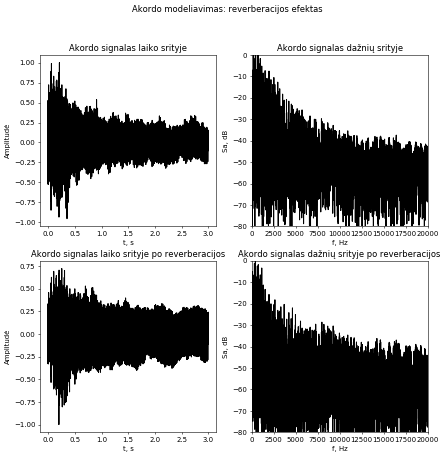

In [10]:
fig, axs = plt.subplots(2,2,figsize=(10,10),dpi=50)
#fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)

time_x = np.linspace(0,ts,len(accord_signal))
axs[0,0].plot(time_x,accord_signal,'k')

axs[0,0].set_ylabel("Amplitudė")
axs[0,0].set_xlabel("t, s")

axs[0,0].set_title("Akordo signalas laiko srityje")

#axs[0].plot(time_x[:3000],accord_signal[:3000],'k')

axs[0,1].plot(accord_f,accord_S,'k')
axs[0,1].set_xlabel('f, Hz')
axs[0,1].set_ylabel('Sa, dB')
#removable limit
axs[0,1].set_xlim([0,20000])
axs[0,1].set_ylim([-80,0])
axs[0,1].set_title("Akordo signalas dažnių srityje")



axs[1,0].plot(time_x,accord_signal_reverberated,'k')

axs[1,0].set_ylabel("Amplitudė")
axs[1,0].set_xlabel("t, s")

axs[1,0].set_title("Akordo signalas laiko srityje po reverberacijos")

#axs[0].plot(time_x[:3000],accord_signal[:3000],'k')

axs[1,1].plot(accord_f_reverberated,accord_S_reverberated,'k')
axs[1,1].set_xlabel('f, Hz')
axs[1,1].set_ylabel('Sa, dB')
#removable limit
axs[1,1].set_xlim([0,20000])
axs[1,1].set_ylim([-80,0])
axs[1,1].set_title("Akordo signalas dažnių srityje po reverberacijos")





fig.suptitle("Akordo modeliavimas: reverberacijos efektas")

plt.show()

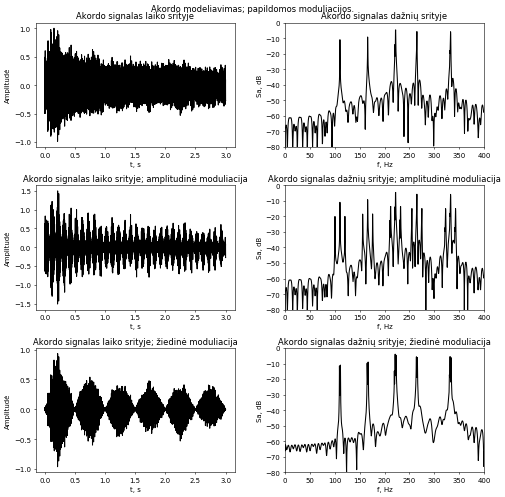

In [4]:
# 4. Papildomos moduliacijos
from copy import copy


def amplitude_modulation(a,fa,fd,x):
    y = copy(x)
    for i in range(len(x)):
        y[i] = (1 + a * np.sin(2*pi*i* fa/fd)) * x[i]
    return y


def ring_modulation(fm,fd,x):
    y = copy(x)
    for i in range(len(x)):
        y[i] = np.sin(2*pi*i* fm/fd) * x[i]
    return y

fs_array = [110,165,220,262,330]
fd = 44100
ts = 3
delays = 0.05

a = 0.7
fa = 10
fm = 1

accord_signal = accord_generation(fs_array,fd,ts,delays)
accord_f,accord_S = convert_to_frequency_domain(accord_signal)


N = 440
K = 0.7
accord_signal_amplitude_modulated = amplitude_modulation(a,fa,fd,accord_signal)
accord_f_amplitude_modulated,accord_S_amplitude_modulated = convert_to_frequency_domain(accord_signal_amplitude_modulated)


accord_signal_ring_modulated = ring_modulation(fm,fd,accord_signal)
accord_f_ring_modulated,accord_S_ring_modulated = convert_to_frequency_domain(accord_signal_ring_modulated)


fig, axs = plt.subplots(3,2,figsize=(10,10),dpi=50,constrained_layout=True)
#fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)

time_x = np.linspace(0,ts,len(accord_signal))
axs[0,0].plot(time_x,accord_signal,'k')

axs[0,0].set_ylabel("Amplitudė")
axs[0,0].set_xlabel("t, s")

axs[0,0].set_title("Akordo signalas laiko srityje")

#axs[0].plot(time_x[:3000],accord_signal[:3000],'k')

axs[0,1].plot(accord_f,accord_S,'k')
axs[0,1].set_xlabel('f, Hz')
axs[0,1].set_ylabel('Sa, dB')
#removable limit
axs[0,1].set_xlim([0,400])
axs[0,1].set_ylim([-80,0])
axs[0,1].set_title("Akordo signalas dažnių srityje")



axs[1,0].plot(time_x,accord_signal_amplitude_modulated,'k')

axs[1,0].set_ylabel("Amplitudė")
axs[1,0].set_xlabel("t, s")

axs[1,0].set_title("Akordo signalas laiko srityje; amplitudinė moduliacija")

#axs[0].plot(time_x[:3000],accord_signal[:3000],'k')

axs[1,1].plot(accord_f_amplitude_modulated,accord_S_amplitude_modulated,'k')
axs[1,1].set_xlabel('f, Hz')
axs[1,1].set_ylabel('Sa, dB')
#removable limit
axs[1,1].set_xlim([0,400])
axs[1,1].set_ylim([-80,0])
axs[1,1].set_title("Akordo signalas dažnių srityje; amplitudinė moduliacija")





axs[2,0].plot(time_x,accord_signal_ring_modulated,'k')

axs[2,0].set_ylabel("Amplitudė")
axs[2,0].set_xlabel("t, s")

axs[2,0].set_title("Akordo signalas laiko srityje; žiedinė moduliacija")

#axs[0].plot(time_x[:3000],accord_signal[:3000],'k')

axs[2,1].plot(accord_f_ring_modulated,accord_S_ring_modulated,'k')
axs[2,1].set_xlabel('f, Hz')
axs[2,1].set_ylabel('Sa, dB')
#removable limit
axs[2,1].set_xlim([0,400])
axs[2,1].set_ylim([-80,0])
axs[2,1].set_title("Akordo signalas dažnių srityje; žiedinė moduliacija")



fig.suptitle("Akordo modeliavimas; papildomos moduliacijos.")

plt.show()

Audio(accord_signal,rate=fd)

In [19]:
Audio(accord_signal_amplitude_modulated,rate=fd)
write('accord_signal_amplitude_modulated.wav',fd, accord_signal_amplitude_modulated)

In [77]:
Audio(accord_signal_ring_modulated,rate=fd)
write('accord_signal_ring_modulated.wav',fd, accord_signal_ring_modulated)


In [20]:
write('accord_signal.wav',fd, accord_signal)